# Identify a MHW

In [110]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
#import regionate as reg

In [111]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [139]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sst = ds_sst.sst.load()

In [140]:
sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
array([[[26.528534, 26.537628, 26.55774 , ...,       nan,       nan,
               nan],
        [26.541504, 26.543457, 26.555145, ...,       nan,       nan,
               nan],
        [26.55774 , 26.549927, 26.557068, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[26.528534, 26.537628, 26.55774 , ...,       nan,       nan,
               nan],
        [26.541504, 26.543457, 26.555145, ...,       nan,       nan,
               nan],
        [26.55774 , 26.549927, 26.557068, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

# Compute daily/monthly climatology and anomaly

In [141]:
#resample to daily to get rid of diurnal cycle
sst_resampled = sst.resample(time='D').mean()

In [6]:
#daily clim
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):

clim = sst_resampled.groupby('time.dayofyear').mean('time')
#clim_std = sst_resampled.groupby('time.dayofyear').std('time')
anom = sst_resampled.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst_resampled.groupby('time.month').mean('time')
#mo_clim_std = sst_resampled.groupby('time.month').std('time')
mo_anom = sst_resampled.groupby('time.month') - mo_clim

In [7]:
anom

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[-0.3977909 , -0.4098568 , -0.41076088, ...,         nan,
                 nan,         nan],
        [-0.408041  , -0.42844772, -0.41965866, ...,         nan,
                 nan,         nan],
        [-0.40283775, -0.43808556, -0.44677544, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.38329506, -0.41287804, -0.41893768, ...,         nan,
                 nan,         nan],
        [-0.3805771 , -0.40377045, -0.3980465 , ...,         nan,
                 nan,         nan],
        [-0.37295532, -0.38967705, -0.39601326, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 264 265 266 267 268 269 270 271

In [142]:
sst_fl = sst_resampled.sel(latitude=slice(22, 31), longitude=slice(-90, -72))
anom_fl = anom.sel(latitude=slice(22, 31), longitude=slice(-90, -72))
clim_fl = clim.sel(latitude=slice(22, 31), longitude=slice(-90, -72))

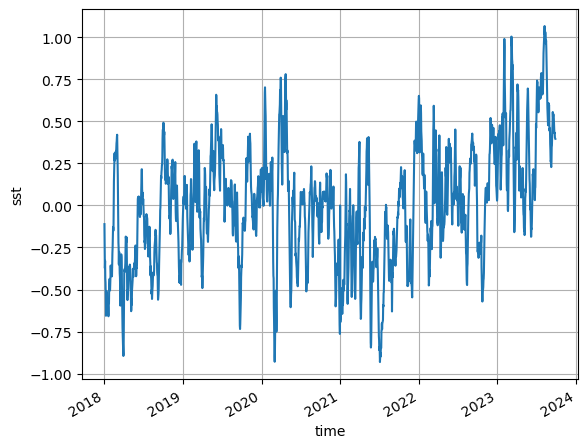

In [11]:
anom_fl.mean(['latitude', 'longitude']).plot()
plt.grid();

In [144]:
#alternative way
may_oct = anom_fl.sel(time=anom_fl.time.dt.month.isin([5, 6, 7, 8, 9, 10]))

In [145]:
may_oct

<xarray.DataArray 'sst' (time: 1071, latitude: 37, longitude: 73)>
array([[[-0.6692791 , -0.6250305 , -0.6690445 , ...,  0.3210392 ,
          0.26649857,  0.18029976],
        [-0.6256809 , -0.65200806, -0.71253777, ...,  0.23675346,
          0.17512321,  0.16586304],
        [-0.67416763, -0.69551086, -0.7018318 , ...,  0.13467026,
          0.15613174,  0.19221878],
        ...,
        [        nan,         nan,         nan, ..., -0.8082924 ,
         -0.7877636 , -0.6030979 ],
        [        nan,         nan,         nan, ..., -0.7182064 ,
         -0.68275833, -0.47676277],
        [        nan,         nan,         nan, ..., -0.46177673,
         -0.5546913 , -0.43232918]],

       [[-0.54756355, -0.5170841 , -0.5229378 , ...,  0.37859535,
          0.30805206,  0.16013908],
        [-0.5502987 , -0.55101013, -0.5396023 , ...,  0.21260834,
          0.13976479,  0.12342072],
        [-0.6188946 , -0.5882187 , -0.50507927, ...,  0.02772141,
          0.03669739,  0.0769825 ],
...
        [        nan,         nan,         nan, ..., -0.24244499,
         -0.20586967, -0.17925262],
        [        nan,         nan,         nan, ..., -0.3509159 ,
         -0.38342476, -0.2165451 ],
        [        nan,         nan,         nan, ..., -0.15508842,
         -0.498909  , -0.51888084]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2018-05-01 2018-05-02 ... 2023-09-28
    dayofyear  (time) int64 121 122 123 124 125 126 ... 266 267 268 269 270 271

In [146]:
anom_may_oct = anom_fl.where(anom_fl.time==may_oct.time)

In [147]:
anom_may_oct.shape

(1071, 37, 73)

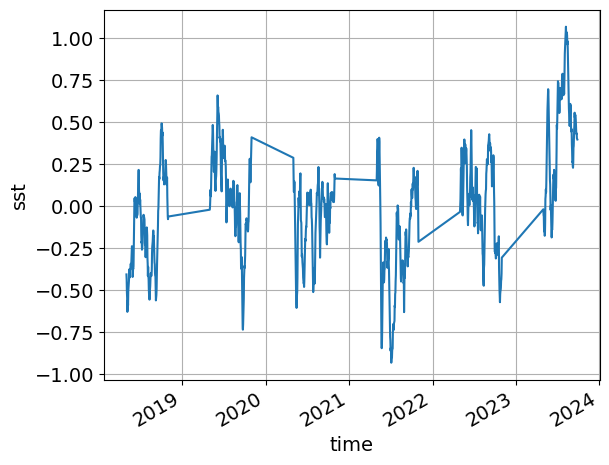

In [148]:
anom_may_oct.mean(['latitude', 'longitude']).plot()
plt.grid();

In [109]:
print('Date where max anom temp occurs:', 
      str(anom_may_oct.mean(['latitude', 'longitude']).idxmax(dim='time').dt.strftime("%Y-%m-%d").values))

Date where max anom temp occurs: 2023-08-08


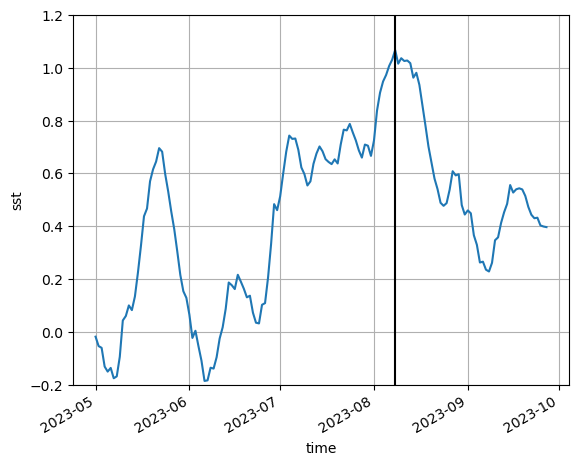

In [97]:
anom_may_oct.sel(time='2023').mean(['latitude', 'longitude']).plot()
plt.vlines(anom_may_oct.mean(['latitude', 'longitude']).idxmax(dim='time').values,
           ymin=-0.2, ymax=1.2, colors='k')
plt.ylim(-0.2, 1.2)
plt.grid();

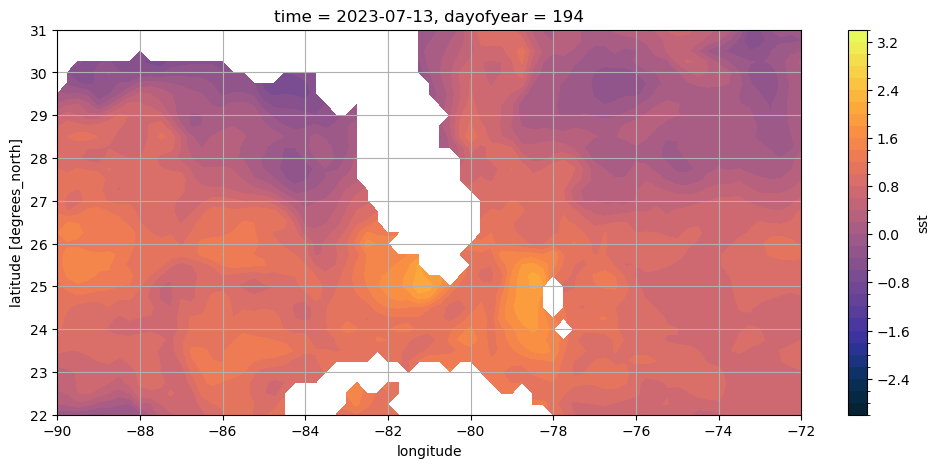

In [9]:
plt.figure(figsize=(12,5))
anom_fl.sel(time='2023-07-13', method='nearest').plot.contourf(levels=np.arange(-3, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

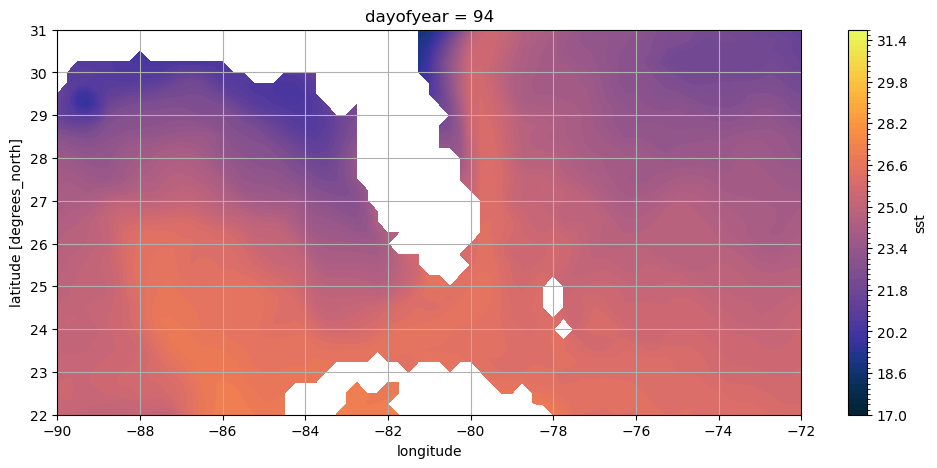

In [117]:
plt.figure(figsize=(12,5))
clim_fl.isel(dayofyear=93).plot.contourf(levels=np.arange(17, 32, 0.2), 
                                         colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

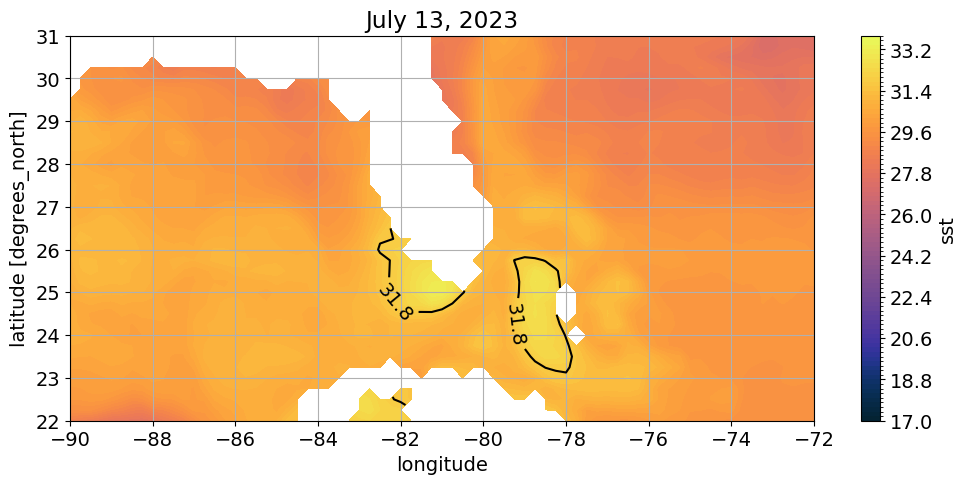

In [149]:
plt.figure(figsize=(12,5))
sst_fl.sel(time='2023-07-13', method='nearest').plot.contourf(levels=np.arange(17, 34, 0.2), 
                                         colors=cmocean.cm.thermal, add_colorbar=True)
c = sst_fl.sel(time='2023-07-13', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('July 13, 2023');

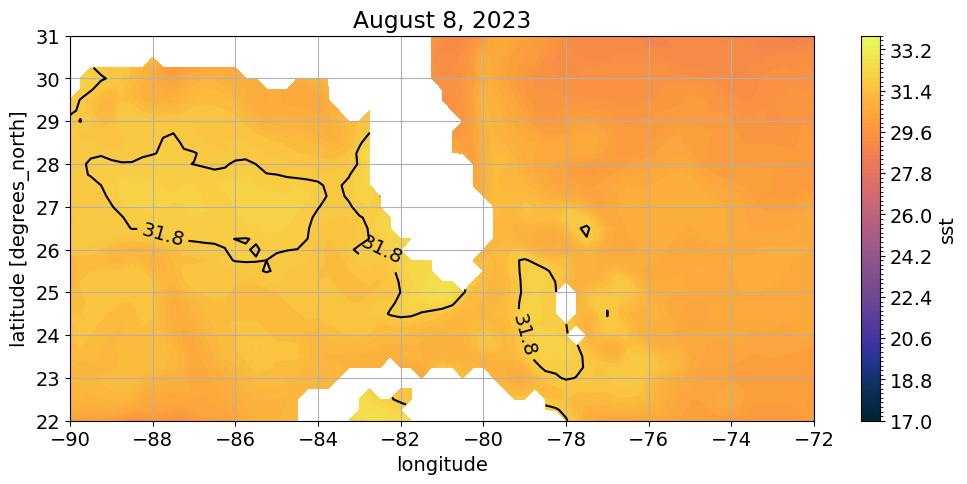

In [150]:
#plot absolute temp based on date associated with largest anomaly
plt.figure(figsize=(12,5))
sst_fl.sel(time='2023-08-08', method='nearest').plot.contourf(levels=np.arange(17, 34, 0.2), 
                                         colors=cmocean.cm.thermal, add_colorbar=True)
c = sst_fl.sel(time='2023-08-08', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('August 8, 2023');

In [16]:
idxmax_anom = anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).idxmax(dim='time', skipna=True)
idxmax_clim = clim_fl.isel(dayofyear=slice(93, 125)).idxmax(dim='dayofyear', skipna=True)

In [20]:
argmax_anom = anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).fillna(0.).argmax(dim='time')
argmax_clim = clim_fl.isel(dayofyear=slice(93,125)).fillna(0.).argmax(dim='dayofyear')

In [21]:
argmax_clim

<xarray.DataArray 'sst' (latitude: 37, longitude: 73)>
array([[31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       [31, 31, 31, ..., 31, 31, 31],
       ...,
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31],
       [ 0,  0,  0, ..., 31, 31, 31]])
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0

In [22]:
argmax_anom.values.max()

30

In [23]:
argmax_clim.max().values

array(31)

In [131]:
mask = anom_fl[0].isnull()

/tmp/ipykernel_440/1634276531.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


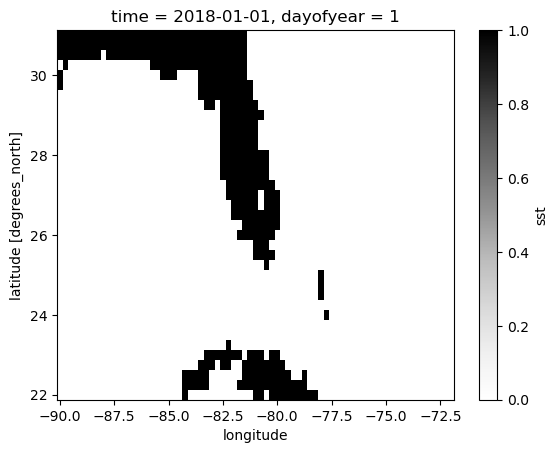

In [132]:
cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap)

/tmp/ipykernel_2007/3382194161.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


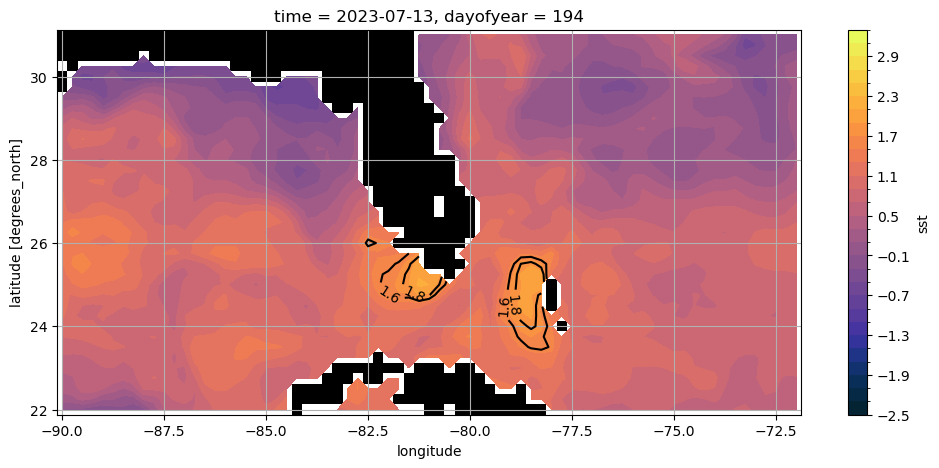

In [26]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap, add_colorbar=False)

anom_fl.sel(time='2023-07-13', method='nearest').plot.contourf(levels=np.arange(-2.5, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = anom_fl.sel(time='2023-07-13', method='nearest').plot.contour(levels=[1.6, 1.8], colors='k')
plt.clabel(c)
plt.grid();

/tmp/ipykernel_2007/2750899400.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Greys")


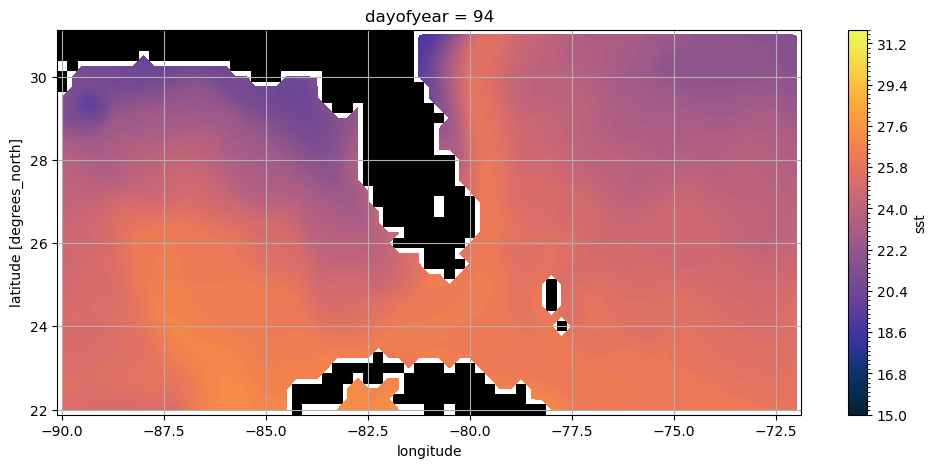

In [27]:
plt.figure(figsize=(12,5))

cmap = plt.cm.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask.plot(cmap=cmap, add_colorbar=False)

clim_fl.isel(dayofyear=93).plot.contourf(levels=np.arange(15, 32, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.grid();

# Movie

In [89]:
#insert datetime object of same length as `dayofyear` coord in order for movie to run
x = np.arange('2222-01', '2223-01-02', dtype='datetime64[D]')

In [46]:
x.shape

(366,)

In [55]:
clim_ds = clim_fl.to_dataset()

In [56]:
clim_ds['time'] = x

In [59]:
clim_ds

<xarray.Dataset>
Dimensions:    (latitude: 37, longitude: 73, dayofyear: 366, time: 366)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * time       (time) datetime64[ns] 2222-01-01 2222-01-02 ... 2223-01-01
Data variables:
    sst        (dayofyear, latitude, longitude) float32 25.38 25.34 ... 21.91

In [124]:
sst_newcoords = clim_ds.assign_coords(time=x).drop('dayofyear').rename({'dayofyear':'time'})
sst = sst_newcoords.sst

In [125]:
sst

<xarray.DataArray 'sst' (time: 366, latitude: 37, longitude: 73)>
array([[[25.377245, 25.336836, 25.306631, ..., 26.717651, 26.658083,
         26.527847],
        [25.425833, 25.426651, 25.402071, ..., 26.752869, 26.7124  ,
         26.708   ],
        [25.437952, 25.454666, 25.463081, ..., 26.653334, 26.648867,
         26.659311],
        ...,
        [      nan,       nan,       nan, ..., 22.954851, 22.890112,
         22.799622],
        [      nan,       nan,       nan, ..., 22.833902, 22.81273 ,
         22.734621],
        [      nan,       nan,       nan, ..., 22.711647, 22.71855 ,
         22.692808]],

       [[25.34052 , 25.296652, 25.248001, ..., 26.652529, 26.615175,
         26.49034 ],
        [25.387568, 25.384493, 25.35222 , ..., 26.695755, 26.681534,
         26.67642 ],
        [25.404322, 25.421844, 25.419226, ..., 26.635263, 26.626997,
         26.639143],
...
        [      nan,       nan,       nan, ..., 23.016825, 22.968956,
         22.868534],
        [      nan,       nan,       nan, ..., 22.864117, 22.8426  ,
         22.826397],
        [      nan,       nan,       nan, ..., 22.778576, 22.761684,
         22.795046]],

       [[24.846497, 24.810762, 24.833601, ..., 26.403841, 26.410454,
         26.421768],
        [24.871475, 24.866379, 24.94975 , ..., 26.4345  , 26.437391,
         26.530508],
        [24.873026, 24.873781, 24.968857, ..., 26.40448 , 26.381945,
         26.462532],
        ...,
        [      nan,       nan,       nan, ..., 22.065048, 21.989113,
         21.90596 ],
        [      nan,       nan,       nan, ..., 22.089373, 21.989122,
         21.835112],
        [      nan,       nan,       nan, ..., 22.096384, 22.024065,
         21.909815]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2222-01-01 2222-01-02 ... 2223-01-01

In [133]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [134]:
#for absolute temp movie
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    ax = fig.subplots()
    theta_levs = np.arange(20,34,0.1)
    
    #mask out land w/o cartopy
    cmap = plt.cm.get_cmap("Greys")
    cmap.set_bad('red', 1.)
    mask.plot(cmap=cmap, add_colorbar=False)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True, extend='neither')
    c = da.isel(time=tt).plot.contour(levels=[31.8], colors='k')
    plt.clabel(c)
    
    ax.grid()

    return ax, Cf

(<Axes: title={'center': 'time = 2018-07-13'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7fb0e07e5c30>)

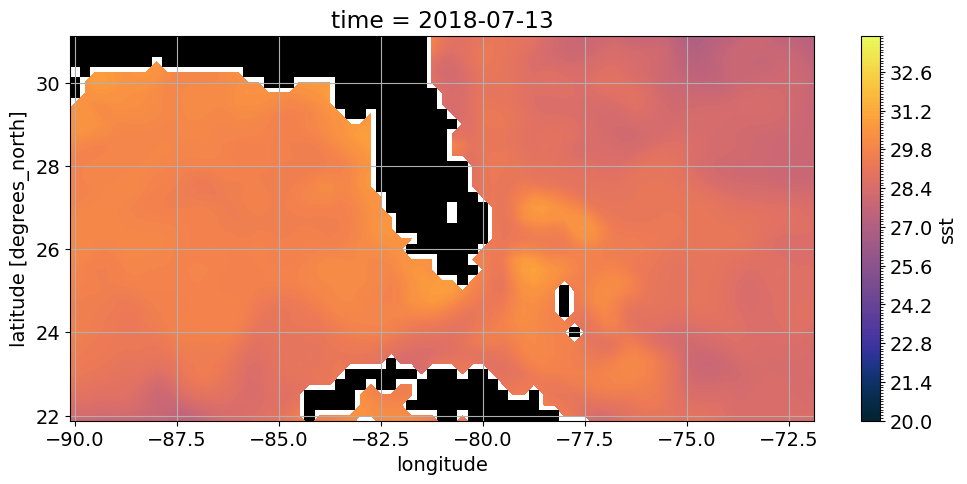

In [151]:
fig = plt.figure(figsize=(12, 5))

contour_surf(sst_resampled, fig, 193)

In [152]:
sst = Movie(sst_resampled, contour_surf, input_check=False)

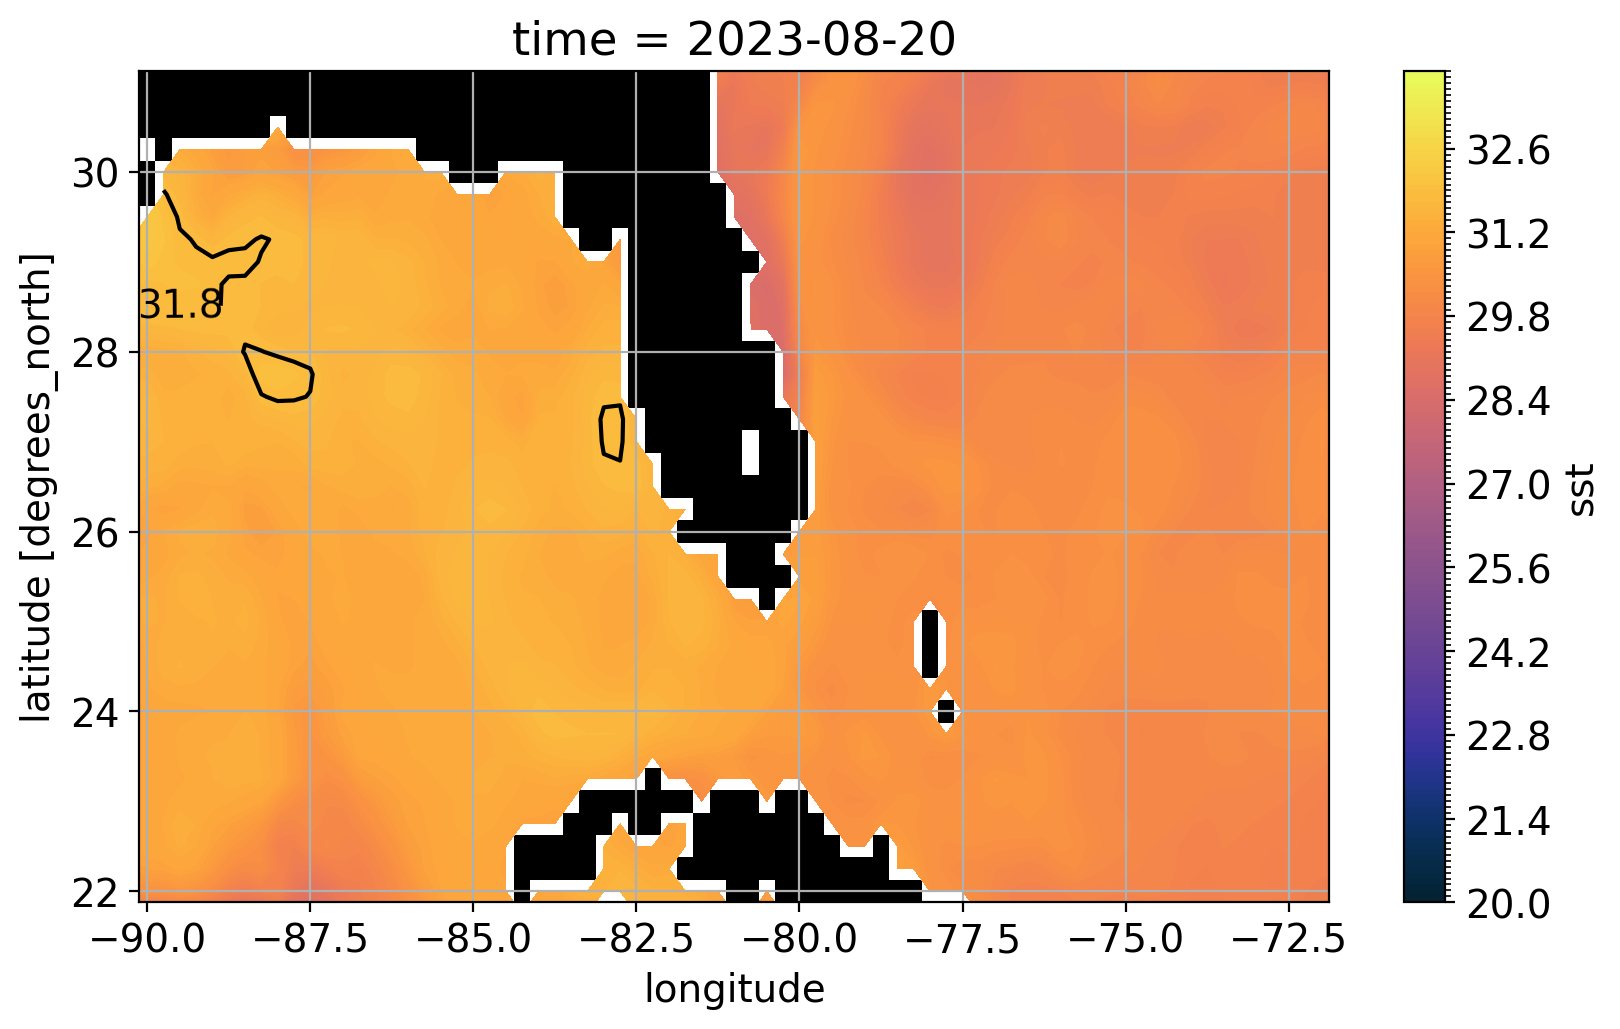

In [153]:
sst.preview(-40)

In [154]:
#save sst movie
sst.save('sst-31_8-contour.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/2097 [00:00<?, ?it/s]

Movie created at sst-31_8-contour.mp4
